In [6]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

import numpy as np
import matplotlib.pyplot as plt

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
epochs = 100
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

In [9]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [10]:
G = generator().to(device)
D = discriminator().to(device)

In [12]:
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [20]:
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 5109613.78it/s]


Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 14453608.62it/s]


Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 6085800.39it/s]


Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4554274.15it/s]

Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw



In [ ]:
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

      
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

Epoch 0 Iteration 100: discriminator_loss 0.617 generator_loss 0.941
Epoch 0 Iteration 200: discriminator_loss 0.685 generator_loss 0.754
Epoch 0 Iteration 300: discriminator_loss 0.645 generator_loss 0.824
Epoch 0 Iteration 400: discriminator_loss 0.615 generator_loss 0.827
Epoch 0 Iteration 500: discriminator_loss 0.573 generator_loss 0.878
Epoch 0 Iteration 600: discriminator_loss 0.509 generator_loss 0.894
Epoch 0 Iteration 700: discriminator_loss 0.491 generator_loss 0.916
Epoch 0 Iteration 800: discriminator_loss 0.506 generator_loss 0.907
Epoch 0 Iteration 900: discriminator_loss 0.546 generator_loss 0.997
Epoch 0 Iteration 938: discriminator_loss 0.502 generator_loss 1.185
Epoch 1 Iteration 100: discriminator_loss 0.456 generator_loss 1.148
Epoch 1 Iteration 200: discriminator_loss 0.414 generator_loss 1.343
Epoch 1 Iteration 300: discriminator_loss 0.464 generator_loss 1.371
Epoch 1 Iteration 400: discriminator_loss 0.462 generator_loss 1.366
Epoch 1 Iteration 500: discriminat

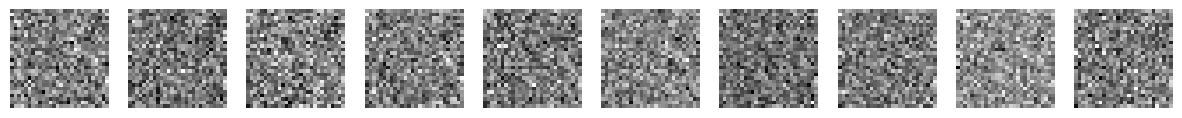

In [20]:
n_images = 10
noise = torch.randn(n_images, 128).to(device)
fake_images = G(noise)

# Denormalize the generated images
fake_images = (fake_images * 0.5) + 0.5

# Convert the generated images to numpy arrays
fake_images = fake_images.cpu().detach().numpy()

# Plot the generated images
fig, axs = plt.subplots(1, n_images, figsize=(15, 15))
for i in range(n_images):
    axs[i].imshow(np.squeeze(fake_images[i]), cmap='gray')
    axs[i].axis('off')
plt.show()

In [3]:
!pip install torch
